In [1]:
!pip install deepspeed
!pip install lightning
!pip install torchmetrics
!pip install torch-fidelity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
  Created wheel for deepspeed: filename=deepspeed-0.16.3-py3-none-any.whl size=1550052 sha256=c5291c7cc3d3f5fa44a5de67f374682fdb55f459ee8ae1450a3dd03863188f33
  Stored in directory: /root/.cache/pip/wheels/ca/e2/8f/3a91068b57481b104c9c450a20239ec874f6141f8b3769e0dd
Successfully built deepspeed
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 16.3 MB/s eta 0:00:00


In [2]:
import glob
import os
import shutil

import deepspeed as ds
import matplotlib.pyplot as plt
import numpy as np
import lightning as L
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from lightning.pytorch.utilities.combined_loader import CombinedLoader
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.utils import make_grid, save_image

_ = L.seed_everything(0, workers=True)

[2025-01-31 10:26:12,884] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


INFO: Seed set to 0


# Show Image Function

In [3]:
def show_img(img_tensor, nrow, title=""):
    img_tensor = img_tensor.detach().cpu() * 0.5 + 0.5
    img_grid = make_grid(img_tensor, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=(18, 8))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Image Augmentation

In [4]:
class CustomTransform(object):
    def __init__(self, load_dim=286, target_dim=256):
        self.transform_train = T.Compose([
            T.Resize((load_dim, load_dim), antialias=True),
            T.RandomCrop((target_dim, target_dim)),
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.2, contrast=0.2,
                          saturation=0.2, hue=0.1),
        ])
        
        # ensure images outside of training dataset are also of the same size
        self.transform = T.Resize((target_dim, target_dim), antialias=True)
        
    def __call__(self, img, stage):
        if stage == "fit":
            img = self.transform_train(img)
        else:
            img = self.transform(img)
        return img * 2 - 1

# Custom Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, filenames, transform, stage):
        self.filenames = filenames
        self.transform = transform
        self.stage = stage
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img = read_image(img_name) / 255.0
        return self.transform(img, stage=self.stage)

In [6]:
# change to True to set the configuration for debugging mode
DEBUG = False
# DEBUG = True

DM_CONFIG = {    
    # the directories where the Monet paintings and photos are loaded from
    "train_mri_dir": os.path.join("/kaggle/input/mri-ct/mri-ct_resized_lanczos/train/mri", "*.png"),
    "train_ct_dir": os.path.join("/kaggle/input/mri-ct/mri-ct_resized_lanczos/train/ct", "*.png"),
    "valid_mri_dir": os.path.join("/kaggle/input/mri-ct/mri-ct_resized_lanczos/val/mri", "*.png"),
    "valid_ct_dir": os.path.join("/kaggle/input/mri-ct/mri-ct_resized_lanczos/val/ct", "*.png"),
    
    "loader_config": {
        # the number of subprocesses (excluding the main process) used for data loading
        "num_workers": os.cpu_count(),
        
        # enable faster data transfer to GPU during training
        "pin_memory": torch.cuda.is_available(),
    },
    
    # the validation/test batch size (mainly for visualization purposes)
    "sample_size": 5,
    
    # the training/prediction batch size
    "batch_size": 12,
}

In [7]:
class CustomDataModule(L.LightningDataModule):
    def __init__(
        self,
        train_mri_dir,
        train_ct_dir,
        valid_mri_dir,
        valid_ct_dir,
        loader_config,
        sample_size,
        batch_size,
    ):
        super().__init__()
        self.loader_config = loader_config
        self.sample_size = sample_size
        self.batch_size = batch_size       
            
        # store file paths
        self.train_mri_filenames = sorted(glob.glob(train_mri_dir))
        self.train_ct_filenames = sorted(glob.glob(train_ct_dir))
        self.valid_mri_filenames = sorted(glob.glob(valid_mri_dir))
        self.valid_ct_filenames = sorted(glob.glob(valid_ct_dir))
        
        # define transformations for image augmentation
        self.transform = CustomTransform()
        
    def setup(self, stage):
        if stage == "fit":
            self.train_mri = CustomDataset(self.train_mri_filenames, self.transform, stage)
            self.train_ct = CustomDataset(self.train_ct_filenames, self.transform, stage)            
            
        if stage in ["fit", "test", "predict"]:
            # to be used for test and prediction datasets as well
            self.valid_mri = CustomDataset(self.valid_mri_filenames, self.transform, None)
            self.valid_ct = CustomDataset(self.valid_ct_filenames, self.transform, None)
            
    def train_dataloader(self):
        loader_config = {
            "shuffle": True,
            "drop_last": False,
            "batch_size": self.batch_size,
            **self.loader_config,
        }
        loader_mri = DataLoader(self.train_mri, **loader_config)
        loader_ct = DataLoader(self.train_ct, **loader_config)
        loaders = {"mri": loader_mri, "ct": loader_ct}
        return CombinedLoader(loaders, mode="max_size_cycle")
    
    def val_dataloader(self):
        return DataLoader(
            self.valid_mri,
            batch_size=self.sample_size,
            **self.loader_config,
        )
    
    def test_dataloader(self):
        return self.val_dataloader()
    
    def predict_dataloader(self):
        return DataLoader(
            self.valid_mri,
            batch_size=self.batch_size,
            **self.loader_config,
        )

    def get_real_img_loader(self):
        return DataLoader(
            self.valid_ct,
            batch_size=self.batch_size,
            **self.loader_config,
        )
        

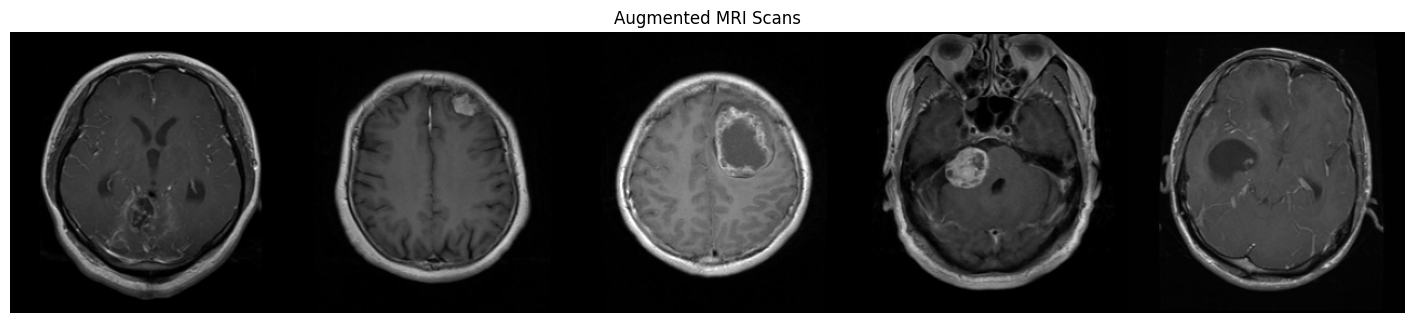

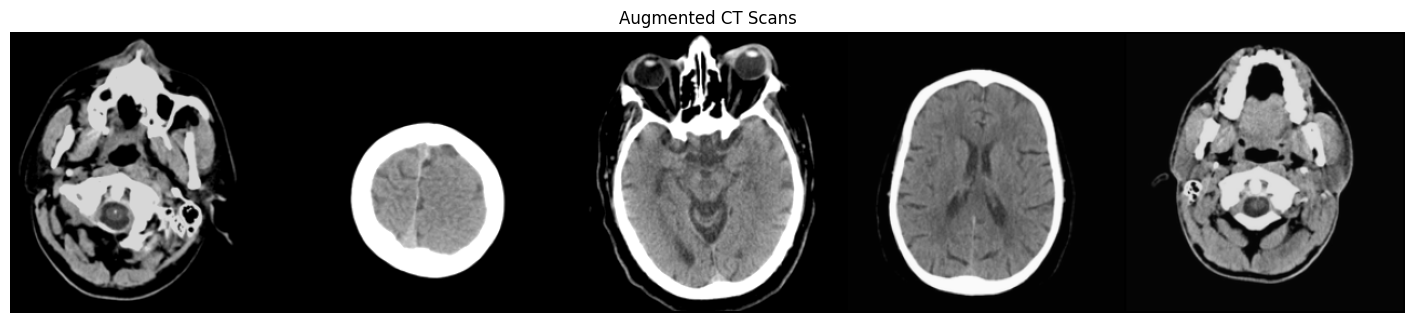

In [8]:
dm_sample = CustomDataModule(batch_size=5, **{k: v for k, v in DM_CONFIG.items() if k != "batch_size"})
dm_sample.setup("fit")

train_loader = dm_sample.train_dataloader()
imgs = next(iter(train_loader))


show_img(imgs[0]["mri"], nrow=5, title="Augmented MRI Scans")
show_img(imgs[0]["ct"], nrow=5, title="Augmented CT Scans")

In [9]:
class Downsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        norm=True,
        lrelu=True,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=not norm),
        )
        if norm:
            self.block.append(nn.InstanceNorm2d(out_channels, affine=True))
        if lrelu is not None:
            self.block.append(nn.LeakyReLU(0.2, True) if lrelu else nn.ReLU(True))
        
    def forward(self, x):
        return self.block(x)

In [10]:
class Upsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        output_padding=0,
        dropout=False,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels,
                               kernel_size=kernel_size, stride=stride, 
                               padding=padding, output_padding=output_padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
        )
        if dropout:
            self.block.append(nn.Dropout(0.5))
        self.block.append(nn.ReLU(True))
        
    def forward(self, x):
        return self.block(x)

In [11]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, kernel_size=3, padding=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(padding),
            Downsampling(in_channels, in_channels,
                         kernel_size=kernel_size, stride=1, padding=0, lrelu=False),
            nn.ReflectionPad2d(padding),
            Downsampling(in_channels, in_channels,
                         kernel_size=kernel_size, stride=1, padding=0, lrelu=None),
        )
        
    def forward(self, x):
        return x + self.block(x)

In [12]:
class UNetGenerator(nn.Module):
    def __init__(self, hid_channels, in_channels, out_channels):
        super().__init__()
        self.downsampling_path = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), # 64x128x128
            Downsampling(hid_channels, hid_channels*2), # 128x64x64
            Downsampling(hid_channels*2, hid_channels*4), # 256x32x32
            Downsampling(hid_channels*4, hid_channels*8), # 512x16x16
            Downsampling(hid_channels*8, hid_channels*8), # 512x8x8
            Downsampling(hid_channels*8, hid_channels*8), # 512x4x4
            Downsampling(hid_channels*8, hid_channels*8), # 512x2x2
            Downsampling(hid_channels*8, hid_channels*8, norm=False), # 512x1x1, instance norm does not work on 1x1
        )
        self.upsampling_path = nn.Sequential(
            Upsampling(hid_channels*8, hid_channels*8, dropout=True), # (512+512)x2x2
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), # (512+512)x4x4
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), # (512+512)x8x8
            Upsampling(hid_channels*16, hid_channels*8), # (512+512)x16x16
            Upsampling(hid_channels*16, hid_channels*4), # (256+256)x32x32
            Upsampling(hid_channels*8, hid_channels*2), # (128+128)x64x64
            Upsampling(hid_channels*4, hid_channels), # (64+64)x128x128
        )
        self.feature_block = nn.Sequential(
            nn.ConvTranspose2d(hid_channels*2, out_channels,
                               kernel_size=4, stride=2, padding=1), # 3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        skips = []
        for down in self.downsampling_path:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])

        for up, skip in zip(self.upsampling_path, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)
        return self.feature_block(x)
    
class ResNetGenerator(nn.Module):
    def __init__(self, hid_channels, in_channels, out_channels, num_resblocks):
        super().__init__()
        self.model = nn.Sequential(
            # downsampling path
            nn.ReflectionPad2d(3),
            Downsampling(in_channels, hid_channels,
                         kernel_size=7, stride=1, padding=0, lrelu=False), # 64x256x256
            Downsampling(hid_channels, hid_channels*2, kernel_size=3, lrelu=False), # 128x128x128
            Downsampling(hid_channels*2, hid_channels*4, kernel_size=3, lrelu=False), # 256x64x64
            
            # residual blocks
            *[ResBlock(hid_channels*4) for _ in range(num_resblocks)], # 256x64x64
            
            # upsampling path
            Upsampling(hid_channels*4, hid_channels*2, kernel_size=3, output_padding=1), # 128x128x128
            Upsampling(hid_channels*2, hid_channels, kernel_size=3, output_padding=1), # 64x256x256
            nn.ReflectionPad2d(3),
            nn.Conv2d(hid_channels, out_channels, kernel_size=7, stride=1, padding=0), # 3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.model(x)
    
def get_gen(gen_name, hid_channels, num_resblocks, in_channels=3, out_channels=3):
    if gen_name == "unet":
        return UNetGenerator(hid_channels, in_channels, out_channels)
    elif gen_name == "resnet":
        return ResNetGenerator(hid_channels, in_channels, out_channels, num_resblocks)
    else:
        raise NotImplementedError(f"Generator name '{gen_name}' not recognized.")

In [13]:
class Discriminator(nn.Module):
    def __init__(self, hid_channels, in_channels=3):
        super().__init__()
        self.block = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), # 64x128x128
            Downsampling(hid_channels, hid_channels*2), # 128x64x64
            Downsampling(hid_channels*2, hid_channels*4), # 256x32x32
            Downsampling(hid_channels*4, hid_channels*8, stride=1), # 512x31x31
            nn.Conv2d(hid_channels*8, 1, kernel_size=4, padding=1), # 1x30x30
        )
        
    def forward(self, x):
        return self.block(x)

In [14]:
# adapted from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/util/image_pool.py
class ImageBuffer(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        if self.buffer_size > 0:
            # the current capacity of the buffer
            self.curr_cap = 0
            # initialize buffer as empty list
            self.buffer = []
    
    def __call__(self, imgs):
        # the buffer is not used
        if self.buffer_size == 0:
            return imgs
        
        return_imgs = []
        for img in imgs:
            img = img.unsqueeze(dim=0)
            
            # fill buffer to maximum capacity
            if self.curr_cap < self.buffer_size:
                self.curr_cap += 1
                self.buffer.append(img)
                return_imgs.append(img)
            else:
                p = np.random.uniform(low=0., high=1.)
                
                # swap images between input and buffer with probability 0.5
                if p > 0.5:
                    idx = np.random.randint(low=0, high=self.buffer_size)
                    tmp = self.buffer[idx].clone()
                    self.buffer[idx] = img
                    return_imgs.append(tmp)
                else:
                    return_imgs.append(img)
        return torch.cat(return_imgs, dim=0)

In [15]:
MODEL_CONFIG = {
    # the type of generator, and the number of residual blocks if ResNet generator is used
    "gen_name": "resnet", # types: 'unet', 'resnet'
    "num_resblocks": 6,
    
    # the number of filters in the first layer for the generators and discriminators
    "hid_channels": 64,
    
    # using DeepSpeed's FusedAdam (currently GPU only) is slightly faster
    "optimizer": ds.ops.adam.FusedAdam if torch.cuda.is_available() else torch.optim.Adam,
    
    # the learning rate and beta parameters for the Adam optimizer
    "lr": 2e-4,
    "betas": (0.5, 0.999),
    
    # the weights used in the identity loss and cycle loss
    "lambda_idt": 0.5,
    "lambda_cycle": (10, 10), # (MPM direction, PMP direction)
    
    # the size of the buffer that stores previously generated images
    "buffer_size": 100,
    
    # the number of epochs for training
    "num_epochs": 120 if not DEBUG else 2, # mainly 120
    
    # the number of epochs before starting the learning rate decay
    "decay_epochs": 10 if not DEBUG else 1,
}

In [16]:
class CycleGAN(L.LightningModule):
    def __init__(
        self,
        gen_name,
        num_resblocks,
        hid_channels,
        optimizer,
        lr,
        betas,
        lambda_idt,
        lambda_cycle,
        buffer_size,
        num_epochs,
        decay_epochs,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.optimizer = optimizer
        self.automatic_optimization = False
        
        # define generators and discriminators
        self.gen_CT_MRI = get_gen(gen_name, hid_channels, num_resblocks)
        self.gen_MRI_CT = get_gen(gen_name, hid_channels, num_resblocks)
        self.disc_MRI = Discriminator(hid_channels)
        self.disc_CT = Discriminator(hid_channels)
        
        # initialize buffers to store fake images
        self.buffer_fake_MRI = ImageBuffer(buffer_size)
        self.buffer_fake_CT = ImageBuffer(buffer_size)
        
    
    def forward(self, img):
        return self.gen_MRI_CT(img)        
            
    def init_weights(self):
        def init_fn(m):
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.InstanceNorm2d)):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
        
        for net in [self.gen_CT_MRI, self.gen_MRI_CT, self.disc_MRI, self.disc_CT]:
            net.apply(init_fn)
        
    def setup(self, stage):
        if stage == "fit":
            self.init_weights()
            print("Model initialized.")
            
    def get_lr_scheduler(self, optimizer):
        def lr_lambda(epoch):
            len_decay_phase = self.hparams.num_epochs - self.hparams.decay_epochs + 1.0
            curr_decay_step = max(0, epoch - self.hparams.decay_epochs + 1.0)
            val = 1.0 - curr_decay_step / len_decay_phase
            return max(0.0, val)
        
        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    
    def configure_optimizers(self):
        opt_config = {
            "lr": self.hparams.lr,
            "betas": self.hparams.betas,
        }
        opt_gen = self.optimizer(
            list(self.gen_CT_MRI.parameters()) + list(self.gen_MRI_CT.parameters()),
            **opt_config,
        )
        opt_disc = self.optimizer(
            list(self.disc_MRI.parameters()) + list(self.disc_CT.parameters()),
            **opt_config,
        )
        optimizers = [opt_gen, opt_disc]
        schedulers = [self.get_lr_scheduler(opt) for opt in optimizers]
        return optimizers, schedulers
        
    def adv_criterion(self, y_hat, y):
        return F.mse_loss(y_hat, y)
    
    def recon_criterion(self, y_hat, y):
        return F.l1_loss(y_hat, y)
    
    def get_adv_loss(self, fake, disc):
        fake_hat = disc(fake)
        real_labels = torch.ones_like(fake_hat)
        adv_loss = self.adv_criterion(fake_hat, real_labels)
        return adv_loss
    
    def get_idt_loss(self, real, idt, lambda_cycle):
        idt_loss = self.recon_criterion(idt, real)
        return self.hparams.lambda_idt * lambda_cycle * idt_loss
    
    def get_cycle_loss(self, real, recon, lambda_cycle):
        cycle_loss = self.recon_criterion(recon, real)
        return lambda_cycle * cycle_loss
    
    def get_gen_loss(self):
        # calculate adversarial loss
        adv_loss_CT_MRI = self.get_adv_loss(self.fake_MRI, self.disc_MRI)
        adv_loss_MRI_CT = self.get_adv_loss(self.fake_CT, self.disc_CT)
        total_adv_loss = adv_loss_CT_MRI + adv_loss_MRI_CT
        
        # calculate identity loss
        lambda_cycle = self.hparams.lambda_cycle
        idt_loss_MRI_MRI = self.get_idt_loss(self.real_MRI, self.idt_MRI, lambda_cycle[0])
        idt_loss_CT_CT = self.get_idt_loss(self.real_CT, self.idt_CT, lambda_cycle[1])
        total_idt_loss = idt_loss_MRI_MRI + idt_loss_CT_CT
        
        # calculate cycle loss
        cycle_loss_MRI_CT_MRI = self.get_cycle_loss(self.real_MRI, self.recon_MRI, lambda_cycle[0])
        cycle_loss_CT_MRI_CT = self.get_cycle_loss(self.real_CT, self.recon_CT, lambda_cycle[1])
        total_cycle_loss = cycle_loss_MRI_CT_MRI + cycle_loss_CT_MRI_CT
        
        # combine losses
        gen_loss = total_adv_loss + total_idt_loss + total_cycle_loss
        return gen_loss
    
    def get_disc_loss(self, real, fake, disc):
        # calculate loss on real images
        real_hat = disc(real)
        real_labels = torch.ones_like(real_hat)
        real_loss = self.adv_criterion(real_hat, real_labels)
        
        # calculate loss on fake images
        fake_hat = disc(fake.detach())
        fake_labels = torch.zeros_like(fake_hat)
        fake_loss = self.adv_criterion(fake_hat, fake_labels)
        
        # combine losses
        disc_loss = (fake_loss + real_loss) * 0.5
        return disc_loss
    
    def get_disc_loss_MRI(self):
        fake_MRI = self.buffer_fake_MRI(self.fake_MRI)
        return self.get_disc_loss(self.real_MRI, fake_MRI, self.disc_MRI)
    
    def get_disc_loss_CT(self):
        fake_CT = self.buffer_fake_CT(self.fake_CT)
        return self.get_disc_loss(self.real_CT, fake_CT, self.disc_CT)
    
    def training_step(self, batch, batch_idx):
        self.real_MRI = batch["mri"]
        self.real_CT = batch["ct"]
        opt_gen, opt_disc = self.optimizers()

        # generate fake images
        self.fake_MRI = self.gen_CT_MRI(self.real_CT)
        self.fake_CT = self.gen_MRI_CT(self.real_MRI)
        
        # generate identity images
        self.idt_MRI = self.gen_CT_MRI(self.real_MRI)
        self.idt_CT = self.gen_MRI_CT(self.real_CT)
        
        # reconstruct images
        self.recon_MRI = self.gen_CT_MRI(self.fake_CT)
        self.recon_CT = self.gen_MRI_CT(self.fake_MRI)
    
        # train generators
        self.toggle_optimizer(opt_gen)
        gen_loss = self.get_gen_loss()        
        opt_gen.zero_grad()
        self.manual_backward(gen_loss)
        opt_gen.step()
        self.untoggle_optimizer(opt_gen)
        
        # train discriminators
        self.toggle_optimizer(opt_disc)
        disc_loss_MRI = self.get_disc_loss_MRI()
        disc_loss_CT = self.get_disc_loss_CT()
        opt_disc.zero_grad()
        self.manual_backward(disc_loss_MRI)
        self.manual_backward(disc_loss_CT)
        opt_disc.step()
        self.untoggle_optimizer(opt_disc)
        
        # record training losses
        metrics = {
            "gen_loss": gen_loss,
            "disc_loss_MRI": disc_loss_MRI,
            "disc_loss_CT": disc_loss_CT,
        }
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
        
    def validation_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "validate")
    
    def test_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "test")
        
    def predict_step(self, batch, batch_idx):
        return self(batch)
    
    def display_results(self, batch, batch_idx, stage):
        real_MRI = batch
        fake_CT = self(real_MRI)
        
        if stage == "validate":
            title = f"Epoch {self.current_epoch+1}: MRI-to-CT Translation"
        else:
            title = f"Sample {batch_idx+1}: MRI-to-CT Translation"

        show_img(
            torch.cat([real_MRI, fake_CT], dim=0),
            nrow=len(real_MRI),
            title=title,
        )
    
    def on_train_epoch_start(self):
        # record learning rates
        curr_lr = self.lr_schedulers()[0].get_last_lr()[0]
        self.log("lr", curr_lr, on_step=False, on_epoch=True, prog_bar=True)
        
    def on_train_epoch_end(self):
        # update learning rates
        for sch in self.lr_schedulers():
            sch.step()
        
        # print current state of epoch
        logged_values = self.trainer.progress_bar_metrics
        print(
            f"Epoch {self.current_epoch+1}",
            *[f"{k}: {v:.5f}" for k, v in logged_values.items()],
            sep=" - ",
        )
        
    def on_train_end(self):
        print("Training ended.")
        
    def on_predict_epoch_end(self):
        predictions = self.trainer.predict_loop.predictions
        num_batches = len(predictions)
        batch_size = predictions[0].shape[0]
        last_batch_diff = batch_size - predictions[-1].shape[0]
        print(f"Number of images generated: {num_batches*batch_size-last_batch_diff}.")

In [17]:
TRAIN_CONFIG = {
    "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
    
    # train on 16-bit precision
    "precision": "16-mixed" if torch.cuda.is_available() else 32,
    
    # train on multi GPU
    "devices": [0],
    
    # save checkpoint only for last epoch by default
    "enable_checkpointing": True,
    
    # disable logging for simplicity
    "logger": False,
    
    # the number of epochs for training (we limit the number of train/predict batches during debugging)
    "max_epochs": MODEL_CONFIG["num_epochs"],
    "limit_train_batches": 1.0 if not DEBUG else 2,
    "limit_predict_batches": 1.0,
    
    # the maximum amount of time for training, in case we exceed run-time of 5 hours
    # "max_time": {"hours": 8, "minutes": 45},
    
    # use a small subset of photos for validation/testing (we limit here for flexibility)
    "limit_val_batches": 1,
    "limit_test_batches": 2,
    
    # disable sanity check before starting the training routine
    "num_sanity_val_steps": 0,
    
    # the frequency to visualize the progress of adding Monet style
    "check_val_every_n_epoch": MODEL_CONFIG["num_epochs"] if not DEBUG else 1,

    # disable progress bar
    "enable_progress_bar": False
}

In [18]:
main_folder = f'/kaggle/working/{MODEL_CONFIG["gen_name"]}_mri_ct'
ckpt_folder = main_folder
img_gen_foler = f'{main_folder}/gen'
os.makedirs(main_folder, exist_ok=True)
os.makedirs(ckpt_folder, exist_ok=True)
os.makedirs(img_gen_foler, exist_ok=True)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO: `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO: `Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Model initialized.


Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/fused_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/fused_adam/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module fused_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module fused_adam...
INFO: 
  | Name       | Type            | Params | Mode 
-------------------------------------------------------
0 | gen_CT_MRI | ResNetGenerator | 7.8 M  | train
1 | gen_MRI_CT | ResNetGenerator | 7.8 M  | train
2 | disc_MRI   | Discriminator 

Time to load fused_adam op: 33.085474491119385 seconds
Epoch 1 - lr: 0.00020 - gen_loss: 8.99646 - disc_loss_MRI: 0.19300 - disc_loss_CT: 0.18384


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 2 - lr: 0.00020 - gen_loss: 5.15372 - disc_loss_MRI: 0.12122 - disc_loss_CT: 0.13937
Epoch 3 - lr: 0.00020 - gen_loss: 5.05693 - disc_loss_MRI: 0.11647 - disc_loss_CT: 0.13362
Epoch 4 - lr: 0.00020 - gen_loss: 4.93539 - disc_loss_MRI: 0.12111 - disc_loss_CT: 0.12691
Epoch 5 - lr: 0.00020 - gen_loss: 4.81818 - disc_loss_MRI: 0.12621 - disc_loss_CT: 0.14589
Epoch 6 - lr: 0.00020 - gen_loss: 4.53938 - disc_loss_MRI: 0.13963 - disc_loss_CT: 0.14070
Epoch 7 - lr: 0.00020 - gen_loss: 4.26834 - disc_loss_MRI: 0.14627 - disc_loss_CT: 0.19032
Epoch 8 - lr: 0.00020 - gen_loss: 4.38742 - disc_loss_MRI: 0.13552 - disc_loss_CT: 0.13854
Epoch 9 - lr: 0.00020 - gen_loss: 4.19785 - disc_loss_MRI: 0.14320 - disc_loss_CT: 0.14329
Epoch 10 - lr: 0.00020 - gen_loss: 4.10555 - disc_loss_MRI: 0.14669 - disc_loss_CT: 0.14510
Epoch 11 - lr: 0.00020 - gen_loss: 4.07457 - disc_loss_MRI: 0.14822 - disc_loss_CT: 0.13280
Epoch 12 - lr: 0.00020 - gen_loss: 3.84159 - disc_loss_MRI: 0.15189 - disc_loss_CT: 0.19

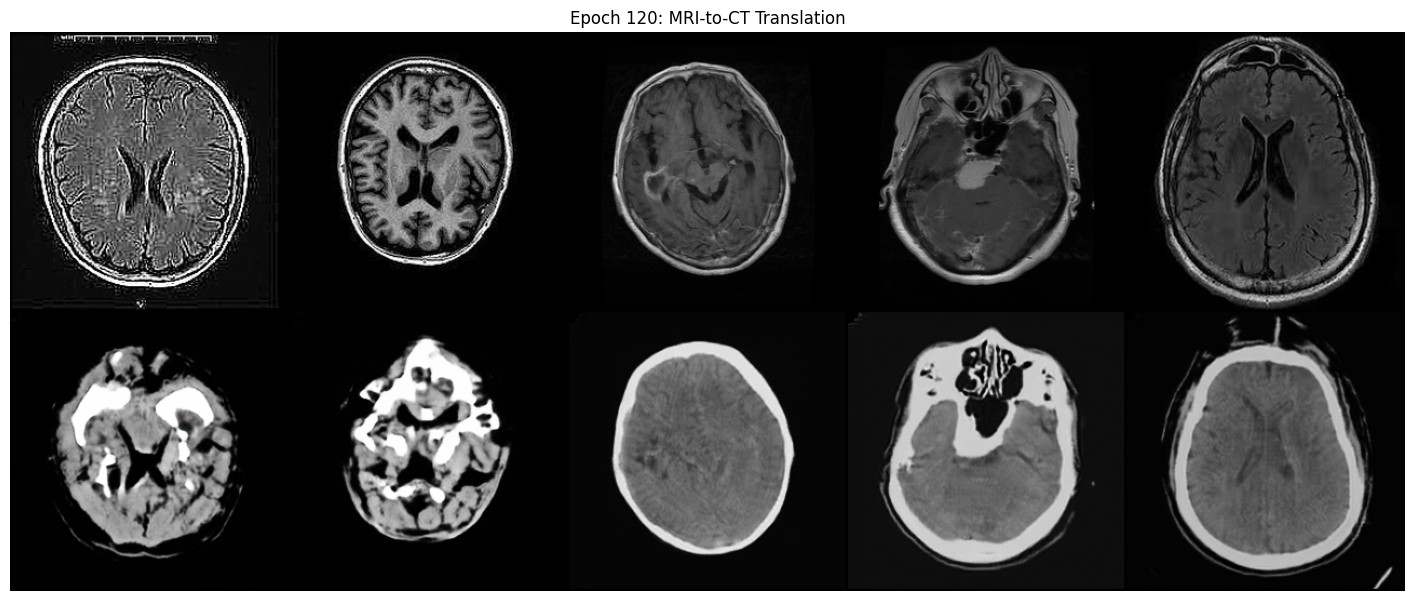

INFO: `Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 120 - lr: 0.00000 - gen_loss: 2.45977 - disc_loss_MRI: 0.16710 - disc_loss_CT: 0.14468
Training ended.


In [19]:
dm = CustomDataModule(**DM_CONFIG)
model = CycleGAN(**MODEL_CONFIG)
trainer = L.Trainer(**TRAIN_CONFIG, default_root_dir=ckpt_folder)

trainer.fit(model, datamodule=dm)

In [20]:
model_path = glob.glob(os.path.join(f'{ckpt_folder}/checkpoints', "*.ckpt"))[0]
model_path

'/kaggle/working/resnet_mri_ct/checkpoints/epoch=119-step=35040.ckpt'

In [21]:
model_eval = CycleGAN.load_from_checkpoint(model_path)

In [22]:
model_eval.eval()

CycleGAN(
  (gen_CT_MRI): ResNetGenerator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Downsampling(
        (block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
      )
      (2): Downsampling(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
      )
      (3): Downsampling(
        (block): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
      )
      (4)

In [23]:
gen_imgs = trainer.predict(model_eval, datamodule=dm)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Number of images generated: 744.


In [24]:
gen_imgs_list = [((img.float().squeeze().unsqueeze(0).unsqueeze(0)) * 0.5 + 0.5) for tensor in gen_imgs for img in tensor]

In [25]:
gen_imgs_catted = torch.cat(gen_imgs_list, dim=0)

In [26]:
real_imgs_list = [((img.float().squeeze().unsqueeze(0).unsqueeze(0)) * 0.5 + 0.5) for tensor in dm.predict_dataloader() for img in tensor]

In [27]:
real_imgs_catted = torch.cat(real_imgs_list, dim=0)

In [28]:
real_img_gen_img = torch.cat([real_imgs_catted, gen_imgs_catted], dim=1)

In [29]:
for idx, img in enumerate(real_img_gen_img, start=1):
    save_image(
        img,
        fp=f'{img_gen_foler}/real_img_gen_img_{idx}.png'
    )
print(f'Saved images')

Saved images


In [30]:
shutil.make_archive(main_folder, 'zip', main_folder)

'/kaggle/working/resnet_mri_ct.zip'